# Evalution and Analysis

## Imports:

In [1]:
from pathlib import Path

## Get predictions and metrics:

In [2]:
from Helper.evaluation_helpers import get_predictions, calc_metrics

In [3]:
predsPath= Path('../Predictions/')
predsDf=get_predictions(predsPath)
display(predsDf)

,ground_truth,GRU,Naive,SARIMAX,ARDL,MLR,NBEATSx,NHITS
observation_date,,,,,,,,
01/2021,106.083,104.798742,105.69,106.038947,105.785040,106.121323,105.880539,106.287415
02/2021,106.471,104.614738,105.69,106.501714,105.785040,106.247963,105.993225,106.401459
03/2021,107.032,104.392772,105.69,106.877229,105.785040,106.374603,106.098434,106.361130
04/2021,107.632,104.176452,105.69,107.086592,105.860227,106.501243,106.191010,106.385925
05/2021,108.184,103.988449,105.69,107.423990,106.270458,106.627884,106.291138,106.396194
06/2021,108.748,103.839441,105.69,107.791156,106.605603,106.754524,106.396713,106.481056
07/2021,109.275,103.721934,105.69,108.105803,106.960277,106.881164,106.486832,106.481674
08/2021,109.720,103.626826,105.69,108.381933,107.328459,107.007804,106.595963,106.550713
09/2021,110.047,103.544718,105.69,108.524800,107.671517,107.134444,106.687790,106.595749


# Calculate Metrics:

In [4]:
# metric DataFrames are sorted by the main metric before being displayed
main_metric = 'RMSE'

## Horizon = 1

In [5]:
# WARNING: r2 is not well defined for less than 2 samples
metrics_1= calc_metrics(predsDf, horizon=1).drop('r2', axis=1)
display(metrics_1.sort_values(main_metric, axis=0))

/uolstore/home/users/sc20geb/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/uolstore/home/users/sc20geb/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/uolstore/home/users/sc20geb/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/uolstore/home/users/sc20geb/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/uolstore/home/users/sc20geb/.local/lib/python3.9/site-packages/sklearn/metrics/_regress

,RMSE,MAE
MLR,0.038323,0.038323
SARIMAX,0.044053,0.044053
NBEATSx,0.202461,0.202461
NHITS,0.204415,0.204415
ARDL,0.29796,0.29796
Naive,0.393,0.393
GRU,1.284258,1.284258


## Horizon = 3

In [6]:
metrics_3= calc_metrics(predsDf, horizon=3)
display(metrics_3.sort_values(main_metric, axis=0))

,RMSE,MAE,r2
SARIMAX,0.094583,0.076513,0.941053
MLR,0.401408,0.306252,-0.061709
NHITS,0.406894,0.314942,-0.09093
NBEATSx,0.616659,0.537934,-1.505672
ARDL,0.83949,0.743627,-3.643714
Naive,0.92473,0.838667,-4.63461
GRU,2.00504,1.926583,-25.489902


## Horizon = 6

In [7]:
metrics_6= calc_metrics(predsDf, horizon=6)
display(metrics_6.sort_values(main_metric, axis=0))

,RMSE,MAE,r2
SARIMAX,0.550375,0.4153,0.651031
MLR,1.166007,0.933184,-0.566292
NHITS,1.315591,1.040942,-0.993938
NBEATSx,1.433454,1.21649,-1.367213
ARDL,1.500273,1.343099,-1.59305
Naive,1.910852,1.668333,-3.206534
GRU,3.309027,3.056568,-11.614523


## Horizon = 12

In [8]:
metrics_12= calc_metrics(predsDf, horizon=12)
display(metrics_12.sort_values(main_metric, axis=0))

,RMSE,MAE,r2
SARIMAX,1.446428,1.142871,0.41294
ARDL,2.314447,2.095828,-0.503084
MLR,2.597792,2.160544,-0.893641
NBEATSx,2.968396,2.53351,-1.472479
NHITS,3.104123,2.549541,-1.70375
Naive,3.786199,3.282,-3.022498
GRU,5.586933,5.067886,-7.758622


# Analysis:

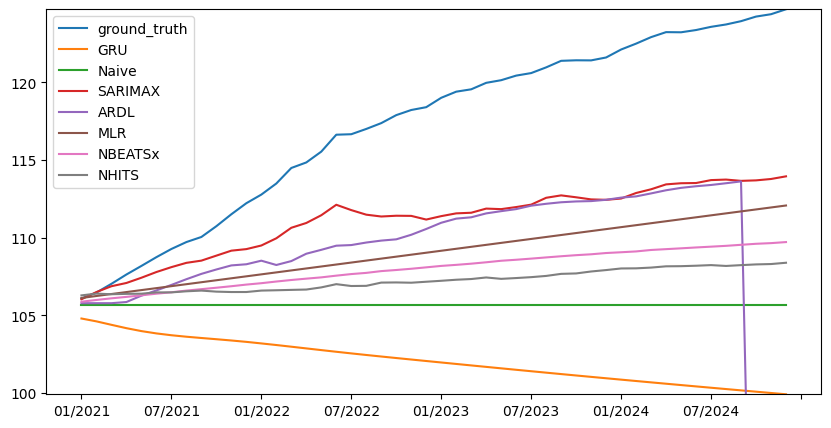

In [9]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
ax = plt.axes()
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.locator_params(axis='x', nbins=10)

for model in predsDf.columns:
    plt.plot(predsDf.index, predsDf[model])

plt.ylim(predsDf.drop('ARDL', axis=1).min(axis=0).min(), predsDf.drop('ARDL', axis=1).max(axis=0).max())
plt.legend(predsDf.columns)

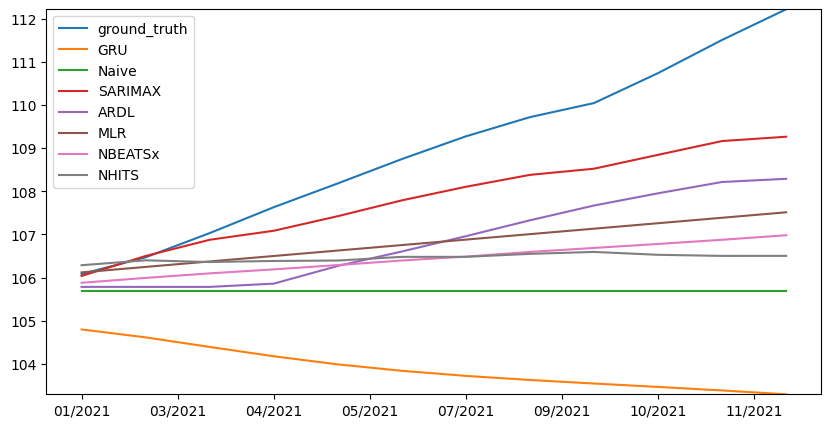

In [11]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
ax = plt.axes()
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.locator_params(axis='x', nbins=10)

for model in predsDf.columns:
    plt.plot(predsDf.index[:int(len(predsDf)/4)], predsDf[model][:int(len(predsDf)/4)])

plt.ylim(predsDf[:int(len(predsDf)/4)].drop('ARDL', axis=1).min(axis=0).min(), predsDf[:int(len(predsDf)/4)].drop('ARDL', axis=1).max(axis=0).max())
plt.legend(predsDf.columns)